# 프로젝트 : 아이유팬이 좋아할 만한 다른 아티스트 찾기
**제가 참가하기로 한 경진대회의 문제 정의가 프로필별 맞춤형 콘텐츠 추천 AI모델 개발입니다.**

## 1. 데이터 준비하기
- **데이터 불러오기**
- **데이터 분석하기**
- **데이터 추가하기**

## 2. 모델 설계하기
- **CSR matrix 만들기**

## 3. 모델 학습하기

## 4. 모델 학습 결과
- **나의 영화 선호도 확인하기**
- **내가 좋아하는 영화와 비슷한 영화 추천받기**
- **내가 좋아할 만한 영화 추천받기**

## 5. 콘텐츠 기반 필터링

In [1]:
import numpy as np
import scipy
import implicit

print(np.__version__)
print(scipy.__version__)
print(implicit.__version__)

1.21.4
1.7.1
0.4.8


- - -
### 데이터 준비하기
- **데이터 불러오기**

In [2]:
import os
import pandas as pd

rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")

ratings

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [3]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   movie_id   1000209 non-null  int64
 2   ratings    1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


사용자가 영화를 보고 남긴 평점 데이터셋입니다.

평점으로 인한 그 영화에 대한 선호도 뿐만 아니라 어떤 영화들을 시청했는지도 알 수 있습니다.

In [4]:
# 3점 이상만 남깁니다.
orginal_data_size = len(ratings)
ratings = ratings[ratings['ratings'] >= 3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


평점을 3점 미만으로 준 데이터는 그 영화를 선호하지 않는다는 것으로 판단하고 학습에서 제외시키겠습니다.

In [5]:
# ratings 컬럼의 이름을 counts로 바꿉니다?? pandas의 rename 함수를 보여주려고 하셨던 것 같습니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [6]:
del ratings['timestamp']

ratings

,user_id,movie_id,counts
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000203,6040,1090,3
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


데이터를 한 눈에 보기 위한 전처리를 진행했습니다.

In [7]:
ratings.isna().sum()

user_id     0
movie_id    0
counts      0
dtype: int64

In [8]:
ratings[ratings.duplicated(subset=['user_id', 'movie_id'])]

,user_id,movie_id,counts


데이터가 중복되거나 같은 영화를 다시 본 데이터는 없군요.

결측치 또한 없습니다.

In [9]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path = os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')

movies

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


사용자 데이터셋과 호환되는 영화에 대한 정보 데이터셋입니다.

In [10]:
movies.isna().sum()

movie_id    0
title       0
genre       0
dtype: int64

In [11]:
movies[movies['movie_id'].duplicated()]

,movie_id,title,genre


- - -
### 데이터 준비하기
- **데이터 전처리**

결측치나 중복은 없습니다.

In [12]:
movies['title']

0                         Toy Story (1995)
1                           Jumanji (1995)
2                  Grumpier Old Men (1995)
3                 Waiting to Exhale (1995)
4       Father of the Bride Part II (1995)
                       ...                
3878               Meet the Parents (2000)
3879            Requiem for a Dream (2000)
3880                      Tigerland (2000)
3881               Two Family House (2000)
3882                 Contender, The (2000)
Name: title, Length: 3883, dtype: object

모델이 학습을 하려면 숫자로 인코딩된 데이터여야 하고

숫자로 되어있는 데이터를 저희가 어떤 영화인지 알려면 영화의 제목과 잘 저장해야겠죠.

영화 제목을 보기 편하게 `title`에 있는 개봉연도를 지우려고 하는데,

개봉연도를 지워도 영화 제목의 유니크함이 남아있을 수 있는지 확인해보겠습니다.

In [13]:
movies[movies['title'].apply(lambda x: 'Titanic' in x)]

,movie_id,title,genre
1672,1721,Titanic (1997),Drama|Romance
2088,2157,"Chambermaid on the Titanic, The (1998)",Romance
3334,3403,Raise the Titanic (1980),Drama|Thriller
3335,3404,Titanic (1953),Action|Drama


생각나는 영화 `Titanic`을 검색해보면 보다시피 같은 영화 제목이 두 개가 나옵니다.

정수로 인코딩을 했는데 영화 제목이 같아버리면  
제가 원하는 타이타닉 영화가 1997년의 타이타닉일지 1953년의 타이타닉일지 알 수 없는 곤란한 상황이 벌어지겠군요.

영화의 제목만으로 영화의 인덱스를 확인하려면 개봉연도를 따로 저장한다고 해서 해결될 일이 아닐 듯 합니다.

In [14]:
ratings.loc[ratings['movie_id']==1721]

,user_id,movie_id,counts
27,1,1721,4
638,8,1721,5
763,9,1721,5
1131,10,1721,3
2192,18,1721,4
...,...,...,...
996628,6016,1721,3
997416,6023,1721,5
997761,6025,1721,4
997923,6027,1721,4


혹시 제목이 같은 두 영화 중 하나를 지워도 괜찮을지

사용자 데이터셋에서 두 영화의 등장 빈도를 검색해봤습니다.

In [15]:
ratings.loc[ratings['movie_id']==3404]

,user_id,movie_id,counts
6761,48,3404,5
8443,58,3404,4
10911,80,3404,5
15539,123,3404,3
16284,129,3404,3
...,...,...,...
987310,5960,3404,4
994671,6007,3404,3
995738,6014,3404,4
997078,6020,3404,4


179개나 되는 데이터를 지우기도 애매할 뿐더러 제목이 같은 영화가 타이타닉 뿐일 것이란 보장이 없기 때문에

그냥 영화 제목에 개봉연도를 남겨두는 것이 더 좋을 것 같습니다.

따라서 타이틀 정규화는 포기합니다.

- - -
### 데이터 준비하기
- **데이터 분석하기**

In [16]:
# 유저 수
ratings['user_id'].nunique()

6039

83만 개의 데이터 중에 사용자는 총 *6039*명입니다.

사용자 한 명당 평균 약 100개가 넘는 영화를 봤다고 볼 수 있군요.

In [17]:
# 영화 수
ratings['movie_id'].nunique()

3628

사용자 데이터셋에 등장하는 영화의 수입니다.

영화 데이터셋의 마지막 인덱스는 *3882*이였는데 확인이 필요해보이는군요.

In [18]:
print(len(movies) - ratings['movie_id'].nunique())

255


사용자 데이터셋에 등장하지 않은 영화의 수가 255개입니다.

그 말은 즉, 영화 데이터셋에 필요가 없는 데이터가 존재한다는 뜻입니다.

아무래도 사용자 데이터셋에서 평점 3점 미만을 준 데이터는 제거해서 발생한 현상인 것 같습니다.

In [19]:
movie_unique = ratings['movie_id'].unique()
movies = movies[movies['movie_id'].apply(lambda x: x in movie_unique)].reset_index(drop=True)

movies

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3623,3948,Meet the Parents (2000),Comedy
3624,3949,Requiem for a Dream (2000),Drama
3625,3950,Tigerland (2000),Drama
3626,3951,Two Family House (2000),Drama


추천 모델에 넣으면 행렬 인수분해가 진행되는데 중간에 비는 인덱스가 생기면 안되니 다시 정렬해줍니다.

In [20]:
movie_idx = {id : i for i, id in enumerate(movies['movie_id'])}
ratings['movie_id'] = ratings['movie_id'].map(movie_idx.get)

ratings

/tmp/ipykernel_188/2725216997.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['movie_id'] = ratings['movie_id'].map(movie_idx.get)


,user_id,movie_id,counts
0,1,1078,5
1,1,627,3
2,1,833,3
3,1,3110,4
4,1,2114,5
...,...,...,...
1000203,6040,996,3
1000205,6040,1000,5
1000206,6040,543,5
1000207,6040,1002,4


**영화 데이터셋**의 `movie_id`를 새로 할당하기 전에 **사용자 데이터셋**의 `movie_id`를 먼저 새로 할당해줍니다.

In [21]:
movies['movie_id'] = movies.index

movies

,movie_id,title,genre
0,0,Toy Story (1995),Animation|Children's|Comedy
1,1,Jumanji (1995),Adventure|Children's|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Waiting to Exhale (1995),Comedy|Drama
4,4,Father of the Bride Part II (1995),Comedy
...,...,...,...
3623,3623,Meet the Parents (2000),Comedy
3624,3624,Requiem for a Dream (2000),Drama
3625,3625,Tigerland (2000),Drama
3626,3626,Two Family House (2000),Drama


그 후에 영화 데이터셋도 id를 새로 할당해줍니다.

In [22]:
movie_to_idx = {title : id for id, title in zip(movies['movie_id'], movies['title'])}

# movie_to_idx 주석을 풀면 판도라의 상자가 열림

    {'Toy Story (1995)': 1,
     'Jumanji (1995)': 2,
     'Grumpier Old Men (1995)': 3,
     'Waiting to Exhale (1995)': 4,
     'Father of the Bride Part II (1995)': 5,
     'Heat (1995)': 6,
     'Sabrina (1995)': 7,
     'Tom and Huck (1995)': 8,
     'Sudden Death (1995)': 9,
     'GoldenEye (1995)': 10,
     'American President, The (1995)': 11,
     'Dracula: Dead and Loving It (1995)': 12,
     'Balto (1995)': 13,
     'Nixon (1995)': 14,
     'Cutthroat Island (1995)': 15,

In [23]:
idx_to_movie = {v: k for k, v in movie_to_idx.items()}

# idx_to_movie 딕셔너리는 슬라이싱이 안되는 것이 아쉽네요.

    {1: 'Toy Story (1995)',
     2: 'Jumanji (1995)',
     3: 'Grumpier Old Men (1995)',
     4: 'Waiting to Exhale (1995)',
     5: 'Father of the Bride Part II (1995)',
     6: 'Heat (1995)',
     7: 'Sabrina (1995)',
     8: 'Tom and Huck (1995)',
     9: 'Sudden Death (1995)',
     10: 'GoldenEye (1995)',
     11: 'American President, The (1995)',
     12: 'Dracula: Dead and Loving It (1995)',
     13: 'Balto (1995)',
     14: 'Nixon (1995)',
     15: 'Cutthroat Island (1995)',

영화 인덱스 인코딩을 다루기 위한 딕셔너리를 준비해봤습니다.

In [24]:
# 사용자들이 많이 본 영화
movies_count = ratings.groupby('movie_id')['user_id'].count()
movies_count = movies_count.sort_values(ascending=False).head(30)

movies_count

movie_id
2600    3211
249     2910
1080    2885
1094    2716
1810    2561
569     2509
573     2498
1082    2473
1152    2460
2325    2434
462     2413
2507    2385
587     2371
106     2314
1419    2297
509     2257
1081    2252
2155    2213
1455    2210
305     2194
785     2167
1147    2121
1003    2102
2734    2066
2462    2051
283     2030
342     2022
1122    2019
0       2000
439     1941
Name: user_id, dtype: int64

인기가 많은 영화를 검색해봤습니다.

영화 라벨링이 영어로 되어있어 무슨 영화인지 알 수가 없네요.

In [25]:
for i, count in movies_count[:30].items():
    print(idx_to_movie[i].ljust(50), ':', count)

American Beauty (1999)                             : 3211
Star Wars: Episode IV - A New Hope (1977)          : 2910
Star Wars: Episode V - The Empire Strikes Back (1980) : 2885
Star Wars: Episode VI - Return of the Jedi (1983)  : 2716
Saving Private Ryan (1998)                         : 2561
Terminator 2: Judgment Day (1991)                  : 2509
Silence of the Lambs, The (1991)                   : 2498
Raiders of the Lost Ark (1981)                     : 2473
Back to the Future (1985)                          : 2460
Matrix, The (1999)                                 : 2434
Jurassic Park (1993)                               : 2413
Sixth Sense, The (1999)                            : 2385
Fargo (1996)                                       : 2371
Braveheart (1995)                                  : 2314
Men in Black (1997)                                : 2297
Schindler's List (1993)                            : 2257
Princess Bride, The (1987)                         : 2252
Shakespeare

아까 만든 딕셔너리를 이용한다면 해결됩니다.

인기가 많은 영화라서 많이 익숙한 영화 제목이 많이 보입니다.

In [26]:
# 사용자별 얼마나 많은 영화에 평점을 남겼는지에 대한 통계
user_count = ratings.groupby('user_id')['movie_id'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: movie_id, dtype: float64

사용자별로 평균 *138*편의 영화를 봤고,

최대로 많이 본 사용자의 경우 적어도 *1968*편의 영화를 보고 평점을 남겼다고 합니다. **WOW**

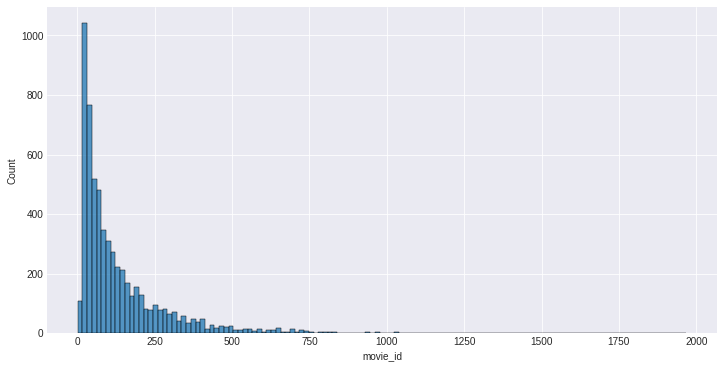

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid') # 그래프 스타일을 꾸며줍니다.

plt.figure(figsize=(12, 6))
sns.histplot(data=user_count)
plt.show()

그래프로 표현하면 이렇습니다.

- - -
### 데이터 준비하기
- **데이터 추가하기**

제가 영화를 많이 안봤을 뿐더러 1995년에서 2000년 사이의 영화는 자주 접해보지 않아가지고

최대한 생각나는 대로 영화 5개를 추려서 사용자 데이터셋에 저에 대한 데이터를 추가해보겠습니다.

In [28]:
[i for i in idx_to_movie.values() if 'Home Alone' in i]

['Home Alone (1990)',
 'Home Alone 3 (1997)',
 'Home Alone 2: Lost in New York (1992)']

영화 제목 정규화에 실패해서 원하는 영화를 검색하려면 위와 같은 방법으로 찾는 게 좋습니다.

영화의 전체 제목이 기억이 나지 않을 때도 유용한 방법입니다.

In [29]:
def search_movie(movie):
    return [i for i in idx_to_movie.values() if movie in i] if type(movie) == str else idx_to_movie[movie]

search_movie('Star Wars')

['Star Wars: Episode IV - A New Hope (1977)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Star Wars: Episode I - The Phantom Menace (1999)']

그리고 그걸 함수로 만들어봤습니다.

인자의 타입이 문자열이면 해당 문자가 포함되는 영화 제목들을, 인자의 타입이 숫자면 해당 숫자를 id로 가진 영화의 제목을 반환합니다.

In [30]:
my_favorite = [
    'Home Alone (1990)',
    'Titanic (1997)',
    'Die Hard (1988)',
    'Truman Show, The (1998)',
    'Star Wars: Episode VI - Return of the Jedi (1983)'
]

for title in my_favorite:
    print(f'{title} : {title in movie_to_idx.keys()}')

Home Alone (1990) : True
Titanic (1997) : True
Die Hard (1988) : True
Truman Show, The (1998) : True
Star Wars: Episode VI - Return of the Jedi (1983) : True


제가 검색한 5개의 영화들입니다.

그리고 제가 추가한 영화 제목에 문제가 없고 잘 검색이 되는지 확인하게끔 출력해봤습니다.

In [31]:
my_favorite = [movie_to_idx[i] for i in my_favorite]

my_favorite

[566, 1540, 949, 1514, 1094]

제가 추가한 영화들의 id입니다.

In [32]:
my_playlist = pd.DataFrame({'user_id': ['Mun']*5, 'movie_id': my_favorite, 'counts':[5]*5})

if not ratings.isin({'user_id':['Mun']})['user_id'].any():
    ratings = ratings.append(my_playlist)

ratings.tail(10)

,user_id,movie_id,counts
1000203,6040,996,3
1000205,6040,1000,5
1000206,6040,543,5
1000207,6040,1002,4
1000208,6040,1003,4
0,Mun,566,5
1,Mun,1540,5
2,Mun,949,5
3,Mun,1514,5
4,Mun,1094,5


`Mun`이라는 유저가 제가 검색한 영화들을 각각 5점씩 줬다는 데이터를 임의로 추가해줬습니다.

제 데이터를 토대로 모델이 과연 비슷한 영화를 추천해줄 수 있을지 기대가 됩니다.

- - -
### 모델 설계하기
- **CSR matrix 만들기**

In [33]:
user_unique = ratings['user_id'].unique()

user_to_idx = {v: k for k, v in enumerate(user_unique)}

배열의 인덱스는 0부터 시작하는데 `user_id`는 1부터 시작하는 것을 정리하는 겸 중간에 비는 인덱스가 없도록

영화 데이터셋의 `movie_id`와 마찬가지로 유저id를 인덱스화 하면서 재정렬하기 위한 딕셔너리입니다.

In [34]:
print(user_to_idx['Mun'])

6039


제 데이터는 *6039*의 인덱스를 가지고 잘 있습니다.

*0*부터 시작했으니 제 데이터를 추가한 후의 총 사용자가 *6040*명이면 마지막은 *6039*의 인덱스를 가져야 정상입니다.

In [35]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = ratings['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(ratings):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    ratings['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

user_id column indexing OK!!


`movie_id`는 위에서 했으니 여기선 생략해줍시다.

In [36]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()

csr_data = csr_matrix((ratings.counts, (ratings.user_id, ratings.movie_id)), shape=(num_user, num_movie))

csr_data

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

사용자×영화(*6040×3628*)의 행렬로 각 사용자마다 각 영화에 대한 선호도 벡터가 만들어졌습니다.

- - -
### 모델 학습하기

In [37]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [38]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [39]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.) 아니 이럴거면 처음부터 item X user로 만들지????
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [40]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

모델 학습이 15초 만에 종료됐습니다.

- - -
### 모델 학습 결과
- **나의 영화 선호도 확인하기**

In [41]:
Mun, Titanic = user_to_idx['Mun'], movie_to_idx['Titanic (1997)']
Mun_vector, Titanic_vector = als_model.user_factors[Mun], als_model.item_factors[Titanic]

대표적으로 저에 대한 사용자 벡터와 타이타닉 영화의 벡터를 확인해보도록 하죠.

In [42]:
Mun_vector

array([ 0.26130772,  0.12153314, -0.31572342, -0.3551459 ,  0.20819712,
       -1.044304  , -0.34516123, -0.31854156, -0.9104711 ,  0.0677297 ,
       -0.5040953 ,  0.4797179 , -0.95998657, -0.15371493, -0.19018471,
        0.7120383 ,  0.22707263, -0.24242876, -0.09567729, -0.37529948,
        0.34314632,  0.46200114, -0.01982164,  0.54478604,  0.33430055,
       -0.23865044,  1.4161224 ,  0.05576517,  0.25922623,  0.16963257,
        0.7322441 ,  1.0151587 ,  0.02927366, -0.31828308,  0.4289882 ,
       -0.07597496, -0.40381142, -0.7778203 ,  0.3907601 ,  0.15658133,
        0.22805077,  0.4444043 ,  0.4360316 ,  0.0158377 , -0.44906184,
        0.86803657, -0.2893605 ,  0.42372367,  0.01824101, -0.20830534,
       -0.01103728, -0.3182503 ,  1.2329347 , -0.39315966, -0.14898318,
       -1.0411654 ,  0.3630126 , -0.12089308,  0.47748464,  0.25600782,
       -0.19314614,  0.06699292,  0.11017838, -0.24331485, -0.8358684 ,
        1.5689662 ,  0.00470726,  0.49968076,  0.33483997, -0.25

In [43]:
Titanic_vector

array([-0.00372485,  0.00619354, -0.01244962, -0.00639248,  0.0207867 ,
       -0.00858065,  0.0023635 , -0.00465974, -0.02815535,  0.03243747,
        0.00085194, -0.02387981,  0.00602401, -0.00952865, -0.0230722 ,
        0.03206567,  0.0424095 ,  0.01875404, -0.00919897,  0.01395185,
        0.03045377, -0.00645427,  0.02416062,  0.00094711,  0.01492134,
       -0.00653851,  0.02136445,  0.02701483,  0.04850592, -0.00742366,
        0.02386043,  0.03035517,  0.00355213, -0.01736896,  0.02273885,
       -0.00060166,  0.0046362 , -0.01900667, -0.00376536,  0.01599026,
        0.02421061,  0.05761165, -0.01922029,  0.00130022, -0.02755581,
        0.04136099, -0.00284315,  0.01080547, -0.01026229, -0.03102223,
        0.02349281,  0.00173942,  0.06128301, -0.02905148,  0.02562502,
        0.01883144,  0.01792842,  0.01966453,  0.01619505,  0.02336213,
        0.00067467, -0.00345232, -0.02401496, -0.02588924, -0.00763957,
        0.03635759,  0.0081636 ,  0.00521721,  0.00346633, -0.02

In [44]:
np.dot(Mun_vector, Titanic_vector)

0.62738246

저와 타이타닉 영화의 코사인 유사도를 보면 0.6이라고 합니다.

제가 타이타닉이란 영화에 5점을 줬기 때문에 기본적으로 높은 유사도는 맞지만

제가 추가한 5개의 영화는 사실 제가 좋아한다기 보단, 생각나는 대로 추가한 무작위 영화였다보니

취향을 검색하지 못해서 1에는 가깝지 않게 나온 것 같습니다.

아마 타이타닉과 비슷한 영화들로 5개를 추가했다면 더 높은 유사도가 나왔을 지 모르는 일입니다.

In [45]:
search_movie(1)

'Jumanji (1995)'

아까는 제가 선호하는 영화와의 유사도를 검색해본 것이였습니다.

그렇다면 아무 관련이 없는 영화는 유사도가 어떻게 나올까요?

In [46]:
Jumanji = movie_to_idx['Jumanji (1995)']
Jumanji_vector = als_model.item_factors[Jumanji]
np.dot(Mun_vector, Jumanji_vector)

0.015755802

코사인 유사도가 0.04로 거의 관련이 없다고 나오고 있습니다.

사실 전 주만지가 무슨 영화인지도 모르겠으니 일치한다고 봐야겠죠?

- - -
### 모델 학습 결과
- **내가 좋아하는 영화와 비슷한 영화 추천받기**

제가 스타워즈 영화를 선호한다고 가정하고 스타워즈와 비슷한 영화를 추천받아보겠습니다.

In [47]:
favorite_movie = 'Star Wars: Episode VI - Return of the Jedi (1983)'
movie_id = movie_to_idx[favorite_movie]
similar_movie = als_model.similar_items(movie_id, N=15)
similar_movie

[(1094, 1.0),
 (1080, 0.8801171),
 (249, 0.7671528),
 (1082, 0.5418527),
 (2377, 0.44739243),
 (342, 0.40817484),
 (1152, 0.39856103),
 (1173, 0.3797919),
 (1122, 0.37759942),
 (2325, 0.3460706),
 (1084, 0.3424192),
 (601, 0.32154718),
 (569, 0.32001898),
 (1081, 0.3140734),
 (385, 0.31354594)]

첫 번째 열은 **영화의 인덱스이자 id**, 두 번째 열은 제가 넣은 영화와의 **코사인 유사도**를 보여줍니다.

In [48]:
[idx_to_movie[i[0]] for i in similar_movie]

['Star Wars: Episode VI - Return of the Jedi (1983)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Raiders of the Lost Ark (1981)',
 'Star Wars: Episode I - The Phantom Menace (1999)',
 'Forrest Gump (1994)',
 'Back to the Future (1985)',
 'Indiana Jones and the Last Crusade (1989)',
 'Terminator, The (1984)',
 'Matrix, The (1999)',
 'Aliens (1986)',
 'Condition Red (1995)',
 'Terminator 2: Judgment Day (1991)',
 'Princess Bride, The (1987)',
 'Open Season (1996)']

영화의 id를 타이틀로 바꿔주면 다음과 같은 내용입니다.

첫 번째 영화는 제가 고른 영화라서 벡터가 완전히 동일한 코사인 유사도 1이 나왔었는데요.

이는 사실 오류라고 볼 수도 있겠습니다. 기준으로 잡은 영화를 새로운 것 마냥 추천해버리면 봤던 것만 계속 또 보게 되겠죠.

마치 천 원짜리 지폐를 주며 "동전으로 바꿔줘" 했는데 다시 천 원짜리 지폐를 받은 셈입니다.

In [49]:
def get_similar_movie(movie_name: str):
    movie_id = movie_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

영화를 기준으로 비슷한 영화들을 추천해주는 함수입니다.

In [50]:
search_movie(0)

'Toy Story (1995)'

이번엔 무작위로 고른 영화와 비슷한 영화들을 추천받아보겠습니다.

다행히 아는 내용의 영화입니다.

In [51]:
get_similar_movie('Toy Story (1995)')

['Toy Story (1995)',
 'Toy Story 2 (1999)',
 "Bug's Life, A (1998)",
 'Babe (1995)',
 'Aladdin (1992)',
 'Groundhog Day (1993)',
 'Lion King, The (1994)',
 "There's Something About Mary (1998)",
 'Pleasantville (1998)',
 'Beauty and the Beast (1991)']

토이 스토리와 비슷한 애니메이션 영화들을 추천해줬습니다.

어째 이게 CV나 NLP보다 성과가 좋은 것 같네요.

In [52]:
search_movie(33)

'Babe (1995)'

In [53]:
get_similar_movie('Babe (1995)')

['Babe (1995)',
 'Toy Story (1995)',
 'Babe: Pig in the City (1998)',
 'Toy Story 2 (1999)',
 'Ed Wood (1994)',
 'Little Princess, A (1995)',
 'Angels in the Outfield (1994)',
 'Player, The (1992)',
 'Matilda (1996)',
 'Secret Garden, The (1993)']

아니 진짜 성능이 좋은데?

번역기도 코사인 유사도 쓰면 안되나요???

- - -
### 모델 학습 결과
- **내가 좋아할 만한 영화 추천받기**

In [54]:
user = user_to_idx['Mun']
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(1082, 0.5442473),
 (1080, 0.49847215),
 (249, 0.4182616),
 (1173, 0.37778217),
 (1122, 0.3070779),
 (2507, 0.26744163),
 (1266, 0.22950181),
 (342, 0.22828901),
 (141, 0.22637463),
 (1124, 0.22267261),
 (1003, 0.21940914),
 (2377, 0.21938454),
 (1895, 0.20926921),
 (2325, 0.20344222),
 (1084, 0.19689241),
 (2183, 0.18462244),
 (1532, 0.18360955),
 (60, 0.18221085),
 (1152, 0.17820725),
 (1974, 0.17495131)]

영화가 아닌 사용자를 기준으로 추천받을 수도 있습니다.

`N` 인자로 추천받을 데이터의 수를 지정할 수 있습니다.

`filter_already_liked_items` 인자는 제가 봤던 영화를 추천하지 않는다는 항목인데 implicit 버전 0.4.2에 버그가 있다고 합니다.

In [55]:
[idx_to_movie[i[0]] for i in movie_recommended]

['Raiders of the Lost Ark (1981)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Indiana Jones and the Last Crusade (1989)',
 'Terminator, The (1984)',
 'Sixth Sense, The (1999)',
 'Jerry Maguire (1996)',
 'Forrest Gump (1994)',
 'Apollo 13 (1995)',
 'Glory (1989)',
 'E.T. the Extra-Terrestrial (1982)',
 'Star Wars: Episode I - The Phantom Menace (1999)',
 'Indiana Jones and the Temple of Doom (1984)',
 'Matrix, The (1999)',
 'Aliens (1986)',
 "You've Got Mail (1998)",
 'Good Will Hunting (1997)',
 "Mr. Holland's Opus (1995)",
 'Back to the Future (1985)',
 'Untouchables, The (1987)']

제가 사용한 버전은 0.4.8이라 봤던 영화를 재추천 하지는 않았네요.

In [56]:
recommended = movie_to_idx['Raiders of the Lost Ark (1981)']
explain = als_model.explain(user, csr_data, itemid=recommended)

In [57]:
[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[('Star Wars: Episode VI - Return of the Jedi (1983)', 0.22820331118762022),
 ('Die Hard (1988)', 0.1539548581464605),
 ('Truman Show, The (1998)', 0.07219635772516961),
 ('Titanic (1997)', 0.059139181640812534),
 ('Home Alone (1990)', 0.023386095425874647)]

왜 이 영화를 추천해줬는지, 이 영화를 추천하는 데에 제가 봤던 영화들이 각각 어느 정도의 영향을 끼쳤는지도 확인할 수 있습니다.

스타워즈가 가장 영향을 크게 끼쳤고, 그 다음으로 다이하드도 꽤 높게 기여한 것을 알 수 있습니다.

그런 고로 미루어보아 `Raiders of the Lost Ark (1981)`는 액션 영화라고 예상할 수 있겠군요.

In [58]:
movies[movies['title']=='Raiders of the Lost Ark (1981)']

,movie_id,title,genre
1082,1082,Raiders of the Lost Ark (1981),Action|Adventure


`Raiders of the Lost Ark (1981)`의 장르는 액션 어드벤쳐입니다.

- - -
### 콘텐츠 기반 필터링

In [59]:
movies.head()

,movie_id,title,genre
0,0,Toy Story (1995),Animation|Children's|Comedy
1,1,Jumanji (1995),Adventure|Children's|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Waiting to Exhale (1995),Comedy|Drama
4,4,Father of the Bride Part II (1995),Comedy


혹시 저만 `genre` 컬럼을 보고 비슷한 장르를 찾아 추천하는 상상을 했나요?

늘 그랬지만 이대로 끝내기 아쉬우니 장르를 이용해 콘텐츠 기반 추천도 시도해봅시다.

In [60]:
genre = set(j for i in movies['genre'] for j in i.split('|'))

genre

{'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

영화 데이터셋에 준비된 장르들입니다.

장르가 한 문자열에 겹쳐진 상태로는 제대로 된 코사인 유사도를 확인할 수 없으니

각 장르별 컬럼으로 원핫인코딩을 해주겠습니다.

In [61]:
for i in genre:
    movies[i] = movies['genre'].apply(lambda x: i in x).astype(int)

movies

,movie_id,title,genre,Film-Noir,Sci-Fi,Western,Action,Horror,War,Musical,...,Animation,Thriller,Fantasy,Comedy,Drama,Romance,Mystery,Children's,Adventure,Crime
0,0,Toy Story (1995),Animation|Children's|Comedy,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
1,1,Jumanji (1995),Adventure|Children's|Fantasy,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
2,2,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,3,Waiting to Exhale (1995),Comedy|Drama,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,4,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3623,3623,Meet the Parents (2000),Comedy,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3624,3624,Requiem for a Dream (2000),Drama,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3625,3625,Tigerland (2000),Drama,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3626,3626,Two Family House (2000),Drama,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


처음 시도해보는 코드였지만 무사히 잘 적용됐습니다.

그런데 영화의 종류가 *3628*개인 것에 비해 기껏해야 1 ~ 3개씩 가지는 장르가 18종류인 것은 겹치는 장르가 굉장히 많을 것 같은데요.

그렇게 되면 대다수의 영화가 코사인 유사도 1에 수렴해서 제대로 된 추천이 되지 못할 것 같으니 인기 영화를 추출해주겠습니다.

In [62]:
ratings

,user_id,movie_id,counts
0,0,1078,5
1,0,627,3
2,0,833,3
3,0,3110,4
4,0,2114,5
...,...,...,...
0,6039,566,5
1,6039,1540,5
2,6039,949,5
3,6039,1514,5


사용자 데이터셋을 봅시다.

In [63]:
movies_count = ratings.groupby('movie_id')['user_id'].count()

movies_count.describe()

count    3628.000000
mean      230.563120
std       355.600954
min         1.000000
25%        23.000000
50%        87.000000
75%       285.000000
max      3211.000000
Name: user_id, dtype: float64

영화별 시청자 수입니다.

평균이 230회, 최대 3211회입니다

사분위표중 75%에 해당하는 285회를 인기 영화의 기준으로 잡겠습니다.

In [64]:
movies_ratings = ratings.groupby('movie_id')['counts'].mean()

movies_ratings.describe()

count    3628.000000
mean        3.767693
std         0.336912
min         3.000000
25%         3.522566
50%         3.749776
75%         4.000000
max         5.000000
Name: counts, dtype: float64

평점도 빼먹을 수 없겠죠.

영화별 평균 평점입니다.

평균 평점이 4점이 넘는 영화를 반응 좋은 인기 영화라고 하겠습니다.

In [65]:
hit_movies = [i for i in range(len(movies)) if movies_count[i] >= 285 and movies_ratings[i] >= 4.0]

hit_movies = movies.loc[hit_movies]

hit_movies

,movie_id,title,genre,Film-Noir,Sci-Fi,Western,Action,Horror,War,Musical,...,Animation,Thriller,Fantasy,Comedy,Drama,Romance,Mystery,Children's,Adventure,Crime
0,0,Toy Story (1995),Animation|Children's|Comedy,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
5,5,Heat (1995),Action|Crime|Thriller,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
16,16,Sense and Sensibility (1995),Drama|Romance,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
28,28,"City of Lost Children, The (1995)",Adventure|Sci-Fi,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
31,31,Twelve Monkeys (1995),Drama|Sci-Fi,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3515,3515,Kelly's Heroes (1970),Action|Comedy|War,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3546,3546,"Naked Gun: From the Files of Police Squad!, Th...",Comedy,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3574,3574,Almost Famous (2000),Comedy|Drama,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
3586,3586,Best in Show (2000),Comedy,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


영화의 취향이 결정되는 다른 정보가 있으면 좋겠지만 주어진 데이터셋은 장르만 확인할 수 있기 때문에

장르만 가지고 각 영화끼리의 코사인 유사도만 구해보겠습니다.

In [66]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(hit_movies.drop(['movie_id', 'title', 'genre'], axis=1).reset_index(drop=True))

print(cosine_sim)
print(cosine_sim.shape)

[[1.         0.         0.         ... 0.40824829 0.57735027 0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.5        0.         0.70710678]
 ...
 [0.40824829 0.         0.5        ... 1.         0.70710678 0.70710678]
 [0.57735027 0.         0.         ... 0.70710678 1.         0.        ]
 [0.         0.         0.70710678 ... 0.70710678 0.         1.        ]]
(391, 391)


인덱스를 `movie_id`로 따로 지정할 수가 없으니 이번에도 행렬 벡터에 빈 인덱스가 없도록 정렬하면서

행렬 벡터의 코사인 유사도를 구해주는 모듈에 집어넣습니다.

In [67]:
similar_movies = list(enumerate(cosine_sim[0]))

sorted_similar_movies = sorted(similar_movies, key=lambda x:x[1], reverse=True)[1:]

print('Toy Story (1995) 와 비슷한 영화')
print('-'*40)
for item in sorted_similar_movies[:5]:
    movie_id = hit_movies.iloc[item[0]].title
    print(f'{movie_id.ljust(30)}, 유사도: {item[1]}, id: {item[0]}')

Toy Story (1995) 와 비슷한 영화
----------------------------------------
Toy Story 2 (1999)            , 유사도: 1.0000000000000002, id: 337
Chicken Run (2000)            , 유사도: 1.0000000000000002, id: 383
Wrong Trousers, The (1993)    , 유사도: 0.816496580927726, id: 114
Grand Day Out, A (1992)       , 유사도: 0.816496580927726, id: 142
Secret of NIMH, The (1982)    , 유사도: 0.816496580927726, id: 261


번외같은 느낌으로 진행하는 거라 그냥 `hit_movies`의 토이 스토리 인덱스를 따로 외워뒀습니다.

토이 스토리와 비슷한 장르를 가진 영화들의 목록이 출력됐습니다.

특히 유사도가 1이란 것은 장르가 완전히 일치했다는 뜻인데 인기 영화를 미리 추려냈기에 다행히 우려했던 상황은 방지했습니다.

In [68]:
hit_movies.iloc[0]

movie_id                                 0
title                     Toy Story (1995)
genre          Animation|Children's|Comedy
Film-Noir                                0
Sci-Fi                                   0
Western                                  0
Action                                   0
Horror                                   0
War                                      0
Musical                                  0
Documentary                              0
Animation                                1
Thriller                                 0
Fantasy                                  0
Comedy                                   1
Drama                                    0
Romance                                  0
Mystery                                  0
Children's                               1
Adventure                                0
Crime                                    0
Name: 0, dtype: object

토이 스토리의 장르는 Animation | Children's | Comedy 입니다.

In [69]:
hit_movies.iloc[337]

movie_id                              2845
title                   Toy Story 2 (1999)
genre          Animation|Children's|Comedy
Film-Noir                                0
Sci-Fi                                   0
Western                                  0
Action                                   0
Horror                                   0
War                                      0
Musical                                  0
Documentary                              0
Animation                                1
Thriller                                 0
Fantasy                                  0
Comedy                                   1
Drama                                    0
Romance                                  0
Mystery                                  0
Children's                               1
Adventure                                0
Crime                                    0
Name: 2845, dtype: object

토이 스토리 2의 장르도 Animation | Children's | Comedy 이구요.

In [70]:
hit_movies.iloc[383]

movie_id                              3433
title                   Chicken Run (2000)
genre          Animation|Children's|Comedy
Film-Noir                                0
Sci-Fi                                   0
Western                                  0
Action                                   0
Horror                                   0
War                                      0
Musical                                  0
Documentary                              0
Animation                                1
Thriller                                 0
Fantasy                                  0
Comedy                                   1
Drama                                    0
Romance                                  0
Mystery                                  0
Children's                               1
Adventure                                0
Crime                                    0
Name: 3433, dtype: object

같이 유사도가 1이 나왔던 `Chicken Run`의 장르 또한 Animation | Children's | Comedy 입니다.

In [71]:
hit_movies.iloc[114]

movie_id                             1041
title          Wrong Trousers, The (1993)
genre                    Animation|Comedy
Film-Noir                               0
Sci-Fi                                  0
Western                                 0
Action                                  0
Horror                                  0
War                                     0
Musical                                 0
Documentary                             0
Animation                               1
Thriller                                0
Fantasy                                 0
Comedy                                  1
Drama                                   0
Romance                                 0
Mystery                                 0
Children's                              0
Adventure                               0
Crime                                   0
Name: 1041, dtype: object

`Wrong Trousers`는 장르가 Animation | Comedy 로 하나가 빗나가면서 코사인 유사도가 0.8이 나왔군요.

## 마무리하며

저희가 작성한 프로젝트는 아카이빙이 되지 못한다 라고 말씀을 들은 적이 있습니다.

심지어 프로젝트 10은 제 실수로 깃허브 링크가 깨져서 미평가되는 일도 발생했습니다.

하지만 저에게 있어서 프로젝트는 공부의 목적이 짙습니다.

이해가 안가던 부분도 프로젝트를 완성하고 나면 말끔하게 해결됩니다.

가끔 이해가 덜 되는 부분도 있긴 한데 가렵던 게 사라지는 정도는 해소가 됩니다.

그래서 제가 작성한 프로젝트가 아무 곳에도 쓰이지 못한다 해도 생각보다 크게 상심이 가진 않을 것 같습니다.

역시 저는 글로 백 번 보는 것보다 코드로 한 번 부딪혀보는 게 더 이해가 잘 되는 것 같습니다.

그래도 링크가 또 깨질까봐 겁은 나는군요...

추천 알고리즘은 의외로 성능이 좋아 꽤 재밌었습니다.

분명 프로젝트를 시작하기 전까지만 해도 Fundamental.28 추천시스템 입문도 다 이해 못했었습니다.

그런데 전처리를 하고 모델에 넣고 오류를 해결하고 성능을 확인하니 자연스럽게 불이 붙어 번외로 콘텐츠 기반 필터링도 시도해보게 됐습니다.

다양한 전처리를 실험해볼 수 있었던 것도 좋은 것 같습니다. LG유플러스 경진대회 데이터셋도 이렇게 나와준다면 얼마나 좋을까요.


~~오늘에일기 끗~~